In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from matplotlib.ticker import AutoMinorLocator

In [2]:
class SpecPlot(object):
    def __init__(self, width_unit=10, height_unit=3) -> None:
        self.spec_list = []
        self.width_unit = width_unit
        self.height_unit = height_unit
    
    def add_spec(self, spec) -> None:
        self.spec_list.append(spec)
    
    def plot(self, smoothed=True, title="") -> None:
        length = len(self.spec_list)
        fig, axs = plt.subplots(nrows=length, 
                    figsize=(self.width_unit, self.height_unit*length))
        if smoothed:
            for i, ax in enumerate(axs):
                ax.plot(self.spec_list[i].wave, self.spec_list[i].flux_sm,
                        label=self.spec_list[i].name, color="black", zorder=2, lw=1.5)
                std = 1/np.sqrt(self.spec_list[i].ivar_sm)
                # ax.plot(self.spec_list[i].wave, (self.spec_list[i].ymin-np.min(std))+std,
                #         color="red", zorder=1, lw=1)
                ax.plot(self.spec_list[i].wave, (0-np.min(std))+std,
                        color="red", zorder=1, lw=1)
                ax.legend(loc="lower right")
                ax.hlines(0, self.spec_list[i].xmin, self.spec_list[i].xmax, color="grey", ls="dotted", lw=2)
                ax.set_xlim(self.spec_list[i].xmin, self.spec_list[i].xmax)
                # ax.set_ylim(self.spec_list[i].ymin, self.spec_list[i].ymax)
                ax.set_ylim(-0.05, self.spec_list[i].ymax)

        else:
            for i, ax in enumerate(axs):
                ax.plot(self.spec_list[i].wave, self.spec_list[i].flux,
                        label=self.spec_list[i].name, color="black", zorder=2, lw=1.5)
                std = 1/np.sqrt(self.spec_list[i].ivar)

                ax.set_xlim(self.spec_list[i].xmin, self.spec_list[i].xmax)
                ax.set_ylim(self.spec_list[i].ymin-0.2, self.spec_list[i].ymax+0.2)
                ax.plot(self.spec_list[i].wave, (self.spec_list[i].ymin-np.min(std))+std-0.2,
                        color="red", zorder=3, lw=1)
                ax.legend(loc="lower right")
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())


        plt.xlabel(r'Observed Wavelength ($\AA$)')
        fig.text(0.06,0.5, r'f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)', ha="center", va="center", rotation=90)
        # plt.ylabel(r'f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)')
        # TODO: title
        # fig.subplots_adjust(hspace=0)

        return fig

class Spectra(object):
    def __init__(self, fits_file, type, name="") -> None:
        if type == "lris":
            hdul = fits.open(fits_file, memmap=True)
            output = Table(hdul[1].data)
            flux = np.array(output['flux'])
            wave = np.array(output['wave'])
            ivar = np.array(output['ivar'])

            self.wave = wave
            self.flux = flux
            self.ivar = ivar

            self.xmin = 7400
            self.xmax = 9700
            self.ymin = -0.05
            self.ymax = 1.0

        elif type == "sdss_template":
            hdul = fits.open(fits_file, memmap=True)
            output = Table(hdul[0].data)
            self.flux = np.array(list(output[0]))
            self.wave = np.linspace(3800, 9200, len(self.flux))
            self.ivar = np.ones_like(self.flux) * np.inf
            
            self.xmin = 7400
            self.xmax = 9700

            xrange = (self.wave<self.xmax) & (self.wave>self.xmin)
            self.ymin = np.min(self.flux[xrange]) - 5
            self.ymax = np.max(self.flux[xrange]) + 5
        
        elif type == "manual": # update flux, wave, iver, ymin, ymax manually
            self.hdul = hdul = fits.open(fits_file, memmap=True)
            self.xmin = 7400
            self.xmax = 9700

        self.name = name

    def update_data(self, func, **kwargs):
        self.wave, self.flux, self.ivar, self.ymin, self.ymax = func(self, kwargs)

    def set_ylim(self, ymin, ymax) -> None:
        self.ymin = ymin
        self.ymax = ymax

    def ivarsmooth(self, window) -> None:
        nflux = (self.flux.shape)[0]
        halfwindow = int(np.floor((np.round(window) - 1)/2))
        shiftarr = np.zeros((nflux, 2*halfwindow + 1))
        shiftivar = np.zeros((nflux, 2*halfwindow + 1))
        shiftindex = np.zeros((nflux, 2*halfwindow + 1))
        indexarr = np.arange(nflux)
        indnorm = np.outer(indexarr,(np.zeros(2 *halfwindow + 1) + 1))
        for i in np.arange(-halfwindow,halfwindow + 1,dtype=int):
            shiftarr[:,i+halfwindow] = np.roll(self.flux,i)
            shiftivar[:, i+halfwindow] = np.roll(self.ivar, i)
            shiftindex[:, i+halfwindow] = np.roll(indexarr, i)
        wh = (np.abs(shiftindex - indnorm) > (halfwindow+1))
        shiftivar[wh]=0.0
        outivar = np.sum(shiftivar,axis=1)
        nzero, = np.where(outivar > 0.0)
        zeroct=len(nzero)
        smoothflux = np.sum(shiftarr * shiftivar, axis=1)
        if(zeroct > 0):
            smoothflux[nzero] = smoothflux[nzero]/outivar[nzero]
        else:
            smoothflux = np.roll(self.flux, 2*halfwindow + 1)

        self.flux_sm = smoothflux
        self.ivar_sm = outivar

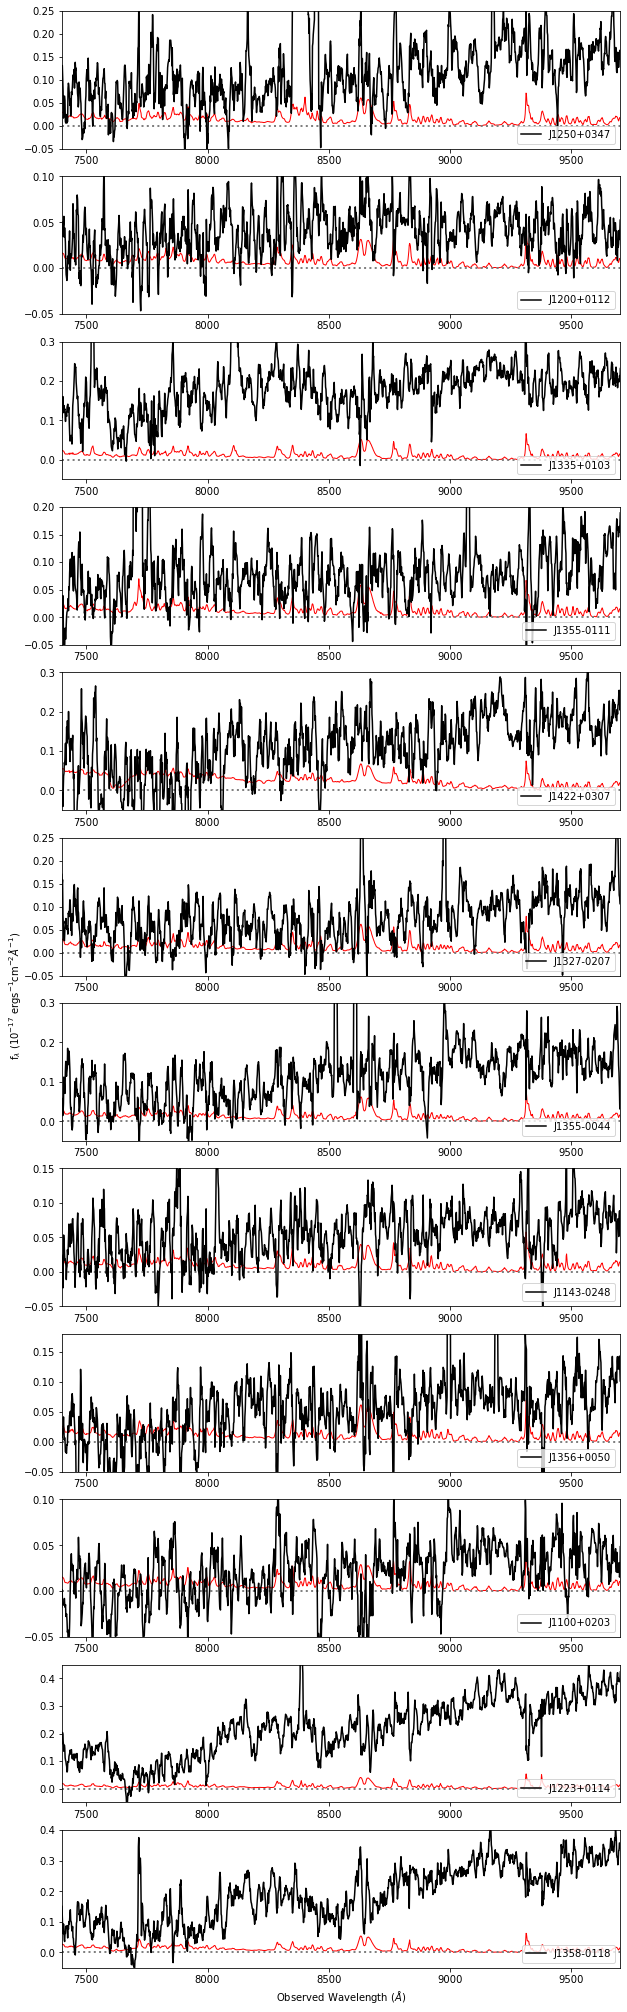

In [66]:
nonqso_targets_0305 = ["J1250+0347", "J1200+0112", "J1335+0103", "J1355-0111", \
                       "J1422+0307", "J1327-0207", "J1355-0044", "J1143-0248", \
                       "J1356+0050", "J1100+0203", "J1223+0114", "J1358-0118"]
ylim_0305 = [(-0.05,0.25), (-0.05,0.1),  (0,0.3),  (-0.05,0.2), \
             (-0.1,0.3),   (-0.05,0.25), (-0.05,0.3), (-0.05,0.15), \
             (-0.1,0.18), (-0.06,0.1),  (-0.05,0.45),  (-0.05,0.4)]
spec_plot = SpecPlot()

for i, target in enumerate(nonqso_targets_0305):
    sp = Spectra("./{}/{}_coadd.fits".format(target,target), type="lris", name=target)
    sp.ivarsmooth(window=7)
    sp.set_ylim(ylim_0305[i][0], ylim_0305[i][1])
    spec_plot.add_spec(sp)

plot = spec_plot.plot(smoothed=True, title="non-quasar (window=7)")
plot.savefig("nonqso_0305_smoothed.pdf", bbox_inches="tight")

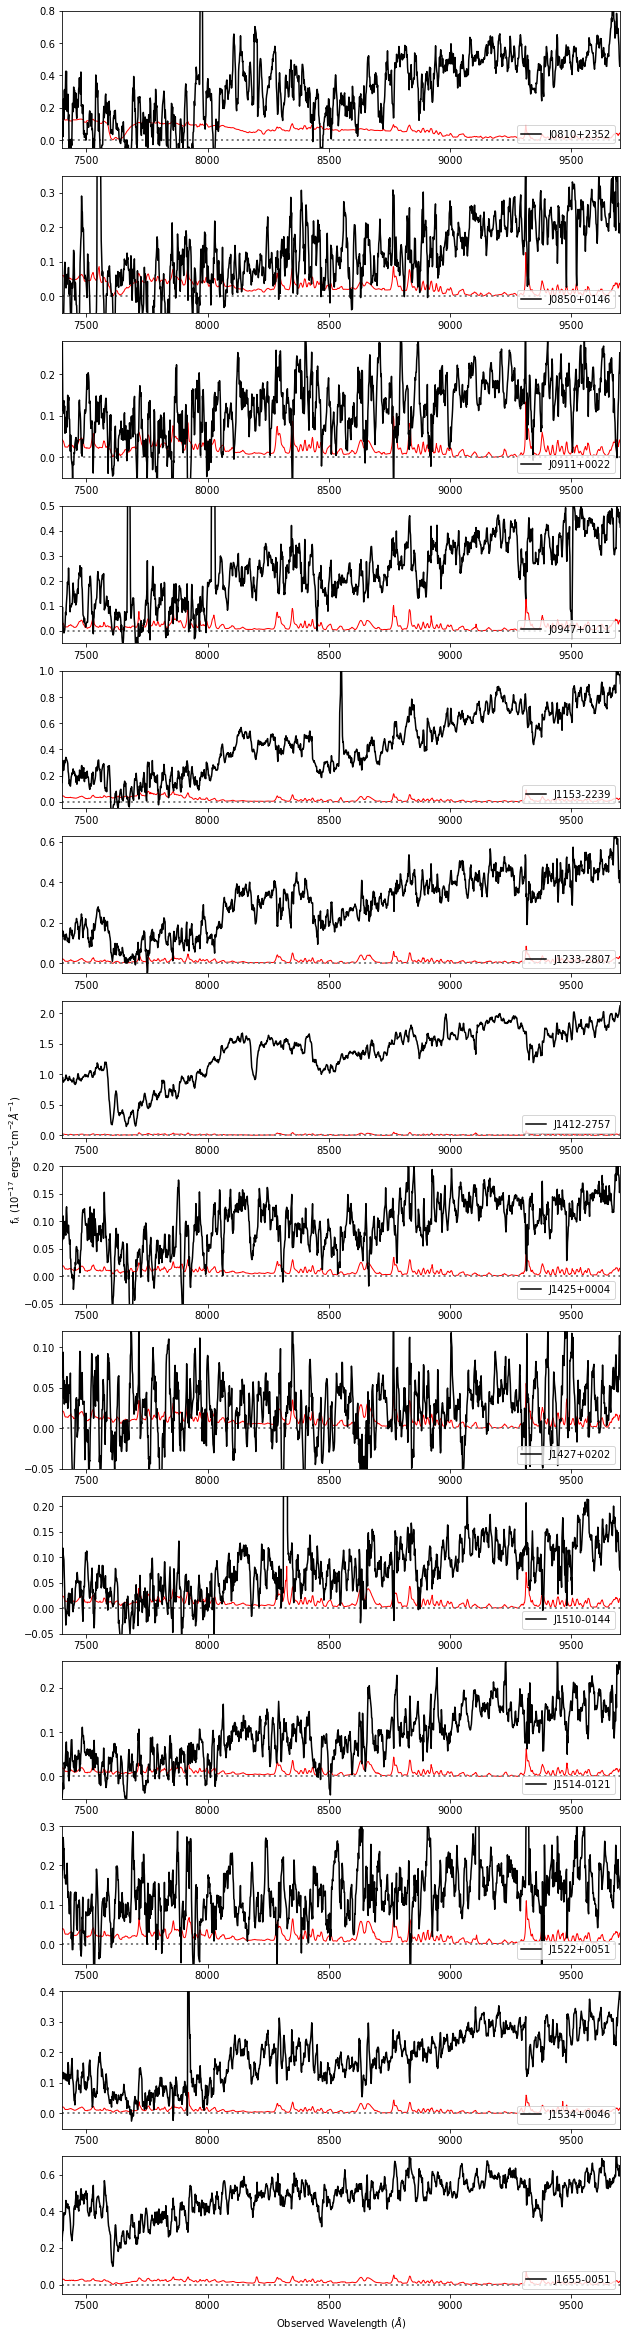

In [68]:
nonqso_targets_0306 = ["J0810+2352", "J0850+0146", "J0911+0022", "J0947+0111", \
                       "J1153-2239", "J1233-2807", "J1412-2757", "J1425+0004", \
                       "J1427+0202", "J1510-0144", "J1514-0121", "J1522+0051", \
                       "J1534+0046", "J1655-0051"]
ylim_0306 = [(-0.2,0.8), (-0.1,0.35), (-0.07,0.28), (-0.05,0.5), \
             (-0.05,1), (0,0.63), (0.1,2.2), (-0.08,0.2), \
             (-0.06,0.12), (-0.06,0.22), (-0.03,0.26), (0,0.3), \
             (-0.02,0.4), (0.1,0.7)]
spec_plot = SpecPlot()

for i, target in enumerate(nonqso_targets_0306):
    sp = Spectra("../../../LRIS_220306/reduced_red/all/{}/{}_coadd.fits".format(target,target), 
                type="lris", name=target)
    sp.ivarsmooth(window=7)
    sp.set_ylim(ylim_0306[i][0], ylim_0306[i][1])
    spec_plot.add_spec(sp)

plot = spec_plot.plot(smoothed=True, title="non-quasar (window=7)")
plot.savefig("nonqso_0306_smoothed.pdf", bbox_inches="tight")

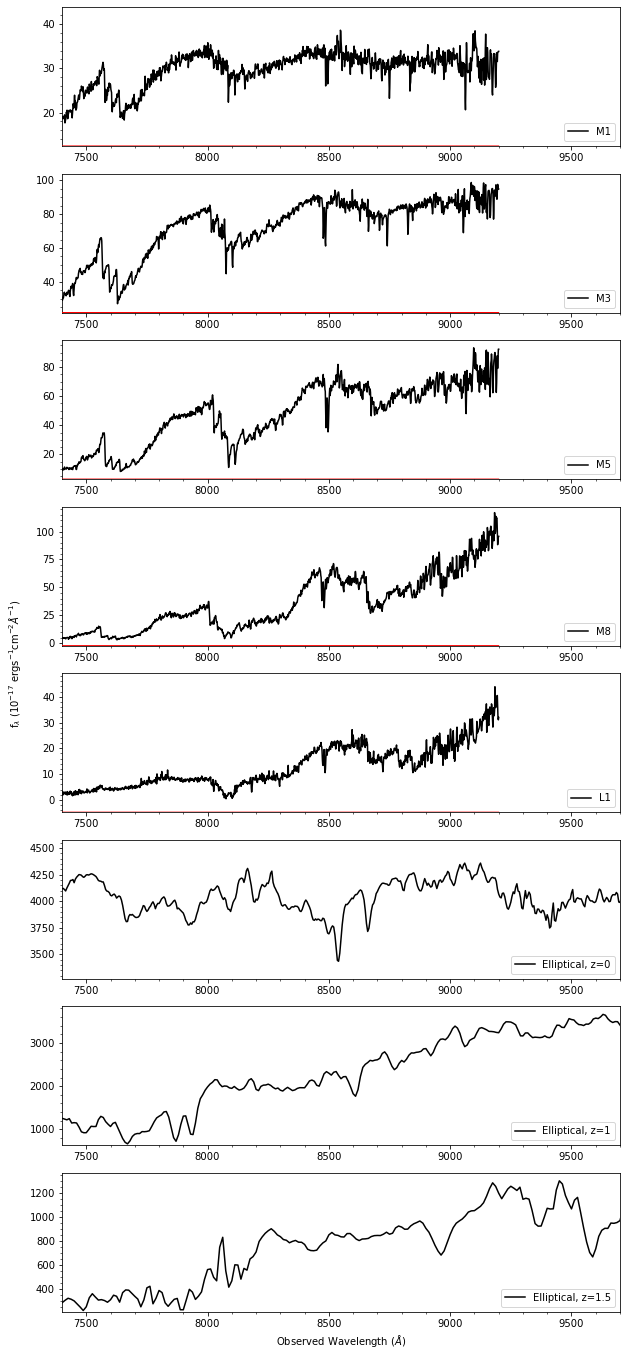

In [5]:
stellar_template_id = [11, 12, 13, 14, 15]
stellar_template = ["M1", "M3", "M5", "M8", "L1"]
spec_plot = SpecPlot()

for i, target in enumerate(stellar_template_id):
    sp = Spectra("../../../template/spectemplatesDR2/spDR2-0{}.fit".format(target), 
                 type="sdss_template", name=stellar_template[i])
    # sp.set_ylim(-1, 1)
    spec_plot.add_spec(sp)

def KC_elliptical(sp, kwargs):
    output = Table(sp.hdul[1].data)
    wave = output["WAVELENGTH"] * (1 + kwargs["redshift"])
    flux = output["FLUX"] / 1e-17
    ivar = np.ones_like(flux) * np.inf
    xrange = (wave<sp.xmax) & (wave>sp.xmin)
    ymin = np.min(flux[xrange]) / 1.05
    ymax = np.max(flux[xrange]) * 1.05
    return wave, flux, ivar, ymin, ymax

for redshift in [0, 1, 1.5]:
    sp = Spectra("../../../template/elliptical_template.fits", 
                    type="manual", name="Elliptical, z={}".format(redshift))
    sp.update_data(KC_elliptical, redshift=redshift)
    spec_plot.add_spec(sp)

plot = spec_plot.plot(smoothed=False)
plot.savefig("template.pdf", bbox_inches="tight")